# Object Detection with YOLOv8

- **Dataset:** The dataset is sourced from [Roboflow](https://public.roboflow.com/ds/6zbwalkMMm?key=z3YTzJ8NNk). [https://public.roboflow.com/ds/6zbwaIkMMm?key=z3YTzJ8NNk]
- **Content:** It contains images and annotations for five vehicle categories — *Ambulance*, *Bus*, *Car*, *Motorcycle*, and *Truck*.  
- **Model:** The YOLOv8-Medium model was used for training.  
- **Goal:** To train and evaluate a real-time object detection model capable of accurately identifying and classifying vehicles in diverse traffic scenes.  


Steps:
1. Install Ultralytics and import required libraries
  - `pip install ultralytics`
  - import `YOLO` from `ultralytics`
  - `os` for operating system related tasks
  - `matplotlib` for viz
  - `cv2` for image processing
  - `requests` for using http request to pull info from the web
  - `numpy` and `random`
  - `pathlib` and `glob` for file and directory handling
  - `datetime` for timestamps
  - `shutil` for file operations
  - `torch` for any DL-related functionality
  - `json` to read metadata
2. Define high level hyperparameter values and configs and check environment
3. Download image and annotation data from RoboFlow (optional - check for corrupted files)
4. Define some utility functions (helper) to inspect a sample of the images with annotation
5. Train the model
6. Validate the model
7. Predict on new data
  - Images from the web
  - Videos from the web


In [1]:
%pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.1 MB/s eta 0:00:00


In [2]:
# step 1
from ultralytics import YOLO
import cv2
import os, pathlib, shutil, glob
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import numpy as np
import random
import json
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# step 2 - CONFIG & Hyperparameters
DATA_YAML     = 'data.yaml' #the downloaded yaml file fo the data - YAML: Yet(YAML) Another Markup Language, the map of the dataset
MODEL_INIT    = 'yolov8m.pt' #start from a small model for faster experimentation
EPOCHS        = 50
BATCH         = 16 #16 is recommended for an initial batch size, which can be increased if needed
IMG           = 640
DEVICE        = 0 if torch.cuda.is_available() else 'cpu' #connect to GPU if it's available
WORKERS       = 4 #used in the DataLoader for parallel CPU image processing
PATIENCE      = 20 # used for earlystoping
SAVE_PERIOD   = 5 # save a snapshot for every 5 epochs
RUN_NAME      = f"train_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
print('Run name:',RUN_NAME)


Run name: train_20251114_185042


In [4]:
#optional - show environment info
try:
  if torch.cuda.is_available():
    print('CUDA Device count:', torch.cuda.device_count())
    print('CUDA Current Device:', torch.cuda.current_device())
    print('CUDA Device name:', torch.cuda.get_device_name())
  else:
    print('Running on CPU')
except Exception as e:
  print('Env info error:',e)

CUDA Device count: 1
CUDA Current Device: 0
CUDA Device name: NVIDIA A100-SXM4-80GB


Build a function to checks if the data exists, if not, then proceed to download the data form the link. Unzip and organize the data into train, text, and validation

In [5]:
# check if the train data exists - helps avoid duplicating downloads and overwriting data
if not os.path.exists('train'):
  #download the file, unzip, delete the zipped file
  !curl -L 'https://public.roboflow.com/ds/6zbwaIkMMm?key=z3YTzJ8NNk' > Vehicles-OpenImages.zip; unzip Vehicles-OpenImages.zip; rm Vehicles-OpenImages.zip

  #define directories
  dirs = ['train', 'valid', 'test']

  #iterate through every directory
  for i, dir_name in enumerate(dirs):
    #get a sorted list of imag enames
    all_img_names = os.listdir(f'{dir_name}/images')
    #iterate through each image
    seen = set()
    removed=0
    unique=0
    for j, img_name in enumerate(all_img_names):
      # to avoid having duplicates
        base_name = img_name.split('.rf.')[0]
        label_name = os.path.splitext(img_name)[0] + '.txt'
        if base_name in seen:
            # remove duplicates
          os.remove(f'{dir_name}/images/{img_name}')
          os.remove(f'{dir_name}/labels/{label_name}')
          removed += 1
        else:
          seen.add(base_name)
          unique += 1

    print('-'*20)
    print(f'{dir_name} orignial: {len(all_img_names)} images')
    print(f'{dir_name} removed: {removed} duplicates')
    print(f'{dir_name} kept: {unique} unique images')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   895  100   895    0     0   1551      0 --:--:-- --:--:-- --:--:--  1551
100 38.4M  100 38.4M    0     0  7124k      0  0:00:05  0:00:05 --:--:-- 10.2M
Archive:  Vehicles-OpenImages.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg  
 extracting: test/images/00dea1edf14f09ab_jpg.rf.KJ730oDTFPdXdJxvSLnX.jpg  
 extracting: test/images/00e481ea1a520175_jpg.rf.6e6a8b3b45c9a11d106958f88ff714ea.jpg  
 extracting: test/images/00e481ea1a520175_jpg.rf.MV6sZ8QCFwFeMYaI2tHm.jpg  
 extracting: test/images/08c8b73e0c2e296e_jpg.rf.7IkYAamjZhnwsoXSrwKt.jpg  
 extracting: test/images/08c8b73e0c2e296e_jpg.rf.effa65856584463c08848031cab357b9.jpg  

- Inspect the structure of the downloaded data (train, test, and valid)
- Check for the images under images sub-folder and annotations under labels sub-folder

### Image and Annotation Inspection
1. Check if every image has its own label file
2. Check if some images have 0 size (no data)
3. Check if some images cannot be read by cv2 library

In [6]:
img_dir = pathlib.Path("/content/train/images")
lbl_dir = pathlib.Path("/content/train/labels")

imgs = sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}])
lbls = [lbl_dir / (p.stem + ".txt") for p in imgs]
missing = [p for p,l in zip(imgs,lbls) if not l.exists()]

print("Images found:", len(imgs))
print("Missing labels:", len(missing))
print("Sample missing:", [p.name for p in missing[:5]])

import cv2
bad = []
for p in imgs:
    im = cv2.imread(str(p))
    if im is None or im.size == 0:
        bad.append(p.name)
print("Corrupt images:", len(bad), bad[:5])

Images found: 439
Missing labels: 0
Sample missing: []
Corrupt images: 0 []


### Check images and annotations

Visualization Helper Functions

We have 3 functions:
1. `yolo2bbox`: Derives the coordinates of bounding box for `matplotlib`
2. `plot_box`: Inherits settings from yolo2bbox and plots the bounding box
3. `load_yolo_annotation`: Loads the annotations
4. `annot_plot`: Inherits from the previous 3 functions to integrate everything together in one plot

In [28]:

def yolo2bbox(bboxes):
    """Convert YOLO format to bbox format - vectorized for efficiency"""
    bboxes = np.array(bboxes)
    if bboxes.ndim == 1:  # Single bbox
        x_c, y_c, w, h = bboxes
        xmin = x_c - w/2
        ymin = y_c - h/2
        xmax = x_c + w/2
        ymax = y_c + h/2
        return np.array([xmin, ymin, xmax, ymax])
    else:  # Multiple bboxes
        x_c, y_c, w, h = bboxes[:, 0], bboxes[:, 1], bboxes[:, 2], bboxes[:, 3]
        xmin = x_c - w/2
        ymin = y_c - h/2
        xmax = x_c + w/2
        ymax = y_c + h/2
        return np.column_stack([xmin, ymin, xmax, ymax])

def plot_box(image, bboxes, labels, class_names, colors):
    """Optimized box plotting function"""
    if not bboxes:  # Handle empty bboxes
        return image

    h, w = image.shape[:2]

    # Convert to numpy arrays for vectorized operations
    bboxes = np.array(bboxes)
    labels = np.array(labels, dtype=int)

    # Convert YOLO to pixel coordinates in one go
    if bboxes.ndim == 1:
        bboxes = bboxes.reshape(1, -1)

    bbox_coords = yolo2bbox(bboxes)

    # Denormalize coordinates
    pixel_coords = bbox_coords * np.array([w, h, w, h])
    pixel_coords = pixel_coords.astype(int)

    # Calculate font scale once
    font_scale = max(0.3, min(1.0, w/1000))
    font_thickness = max(1, min(3, int(w/300)))

    for i, (bbox, label) in enumerate(zip(pixel_coords, labels)):
        xmin, ymin, xmax, ymax = bbox

        # Ensure coordinates are within image bounds
        xmin = max(0, min(xmin, w-1))
        ymin = max(0, min(ymin, h-1))
        xmax = max(0, min(xmax, w-1))
        ymax = max(0, min(ymax, h-1))

        # Get class info
        class_name = class_names[label]
        # color = colors[label % len(colors)]  # Handle case where label > len(colors)

        # colors is RGB float array; OpenCV wants BGR ints
        c = colors[label % len(colors)]
        color = tuple(int(v) for v in c[::-1])  # BGR

        # Draw bounding box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

        # Calculate text size
        (text_w, text_h), baseline = cv2.getTextSize(
            class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
        )

        # Draw text background
        text_bg_coords = (
            (xmin, max(0, ymin - text_h - 5)),
            (xmin + text_w, ymin)
        )
        cv2.rectangle(image, text_bg_coords[0], text_bg_coords[1], color, -1)

        # Draw text
        cv2.putText(
            image, class_name,
            (xmin, ymin - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            # (255, 255, 255),
            (0, 0, 0), # balck text
            font_thickness
        )

    return image

def load_yolo_annotation(label_path):
    """Efficiently load YOLO annotation file"""
    try:
        # Read entire file at once and process with numpy
        data = np.loadtxt(label_path, ndmin=2)  # ndmin=2 handles single line files
        if data.size == 0:
            return [], []

        labels = data[:, 0].astype(int)
        bboxes = data[:, 1:5]
        return bboxes.tolist(), labels.tolist()

    except Exception as e:
        print(f"Error loading {label_path}: {e}")
        return [], []

def annot_plot(image_paths, label_paths, class_names, colors, num_samples=6,
            sp_rows=3, sp_cols=2, figsize=(15, 12), random_seed=None):
    """Optimized plotting function with better error handling"""

    if random_seed is not None:
        random.seed(random_seed)

    # Get and sort file paths
    all_training_images = sorted(glob.glob(image_paths))
    all_training_labels = sorted(glob.glob(label_paths))

    # Validate that we have matching images and labels
    if len(all_training_images) != len(all_training_labels):
        print(f"Warning: Mismatch between images ({len(all_training_images)}) and labels ({len(all_training_labels)})")

    if len(all_training_images) == 0:
        print("No images found!")
        return

    num_images = len(all_training_images)
    actual_samples = min(num_samples, num_images)

    # Pre-select random indices to avoid potential duplicates
    selected_indices = random.sample(range(num_images), actual_samples)

    fig, axes = plt.subplots(sp_rows, sp_cols, figsize=figsize)
    if actual_samples == 1:
        axes = [axes]
    elif sp_rows == 1 or sp_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i, idx in enumerate(selected_indices):
        try:
            # Load image
            image = cv2.imread(all_training_images[idx])
            if image is None:
                print(f"Could not load image: {all_training_images[idx]}")
                continue

            # Load annotations
            bboxes, labels = load_yolo_annotation(all_training_labels[idx])

            # Draw boxes
            result_image = plot_box(image.copy(), bboxes, labels, class_names, colors)

            # Convert BGR to RGB for matplotlib
            result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

            # Plot
            axes[i].imshow(result_image_rgb)
            axes[i].axis('off')
            axes[i].set_title(f'Image {idx}', fontsize=10)

        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            axes[i].axis('off')

    # Hide unused subplots
    for i in range(actual_samples, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [29]:
# metadata needed for the functions above
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

class_colors = np.array([[0.0, 255.0,  0], #green, Ambulance
                        [0, 148, 148], #blue, Bus
                        [255, 255.0,  0],# yellow, Car
                        # [0, 2, 148], # dark blue, Motorcycle
                         [255, 255, 255], # dark blue, Motorcycle
                        [255.0, 0, 20.0] #red, Truck
                        ]
                        )

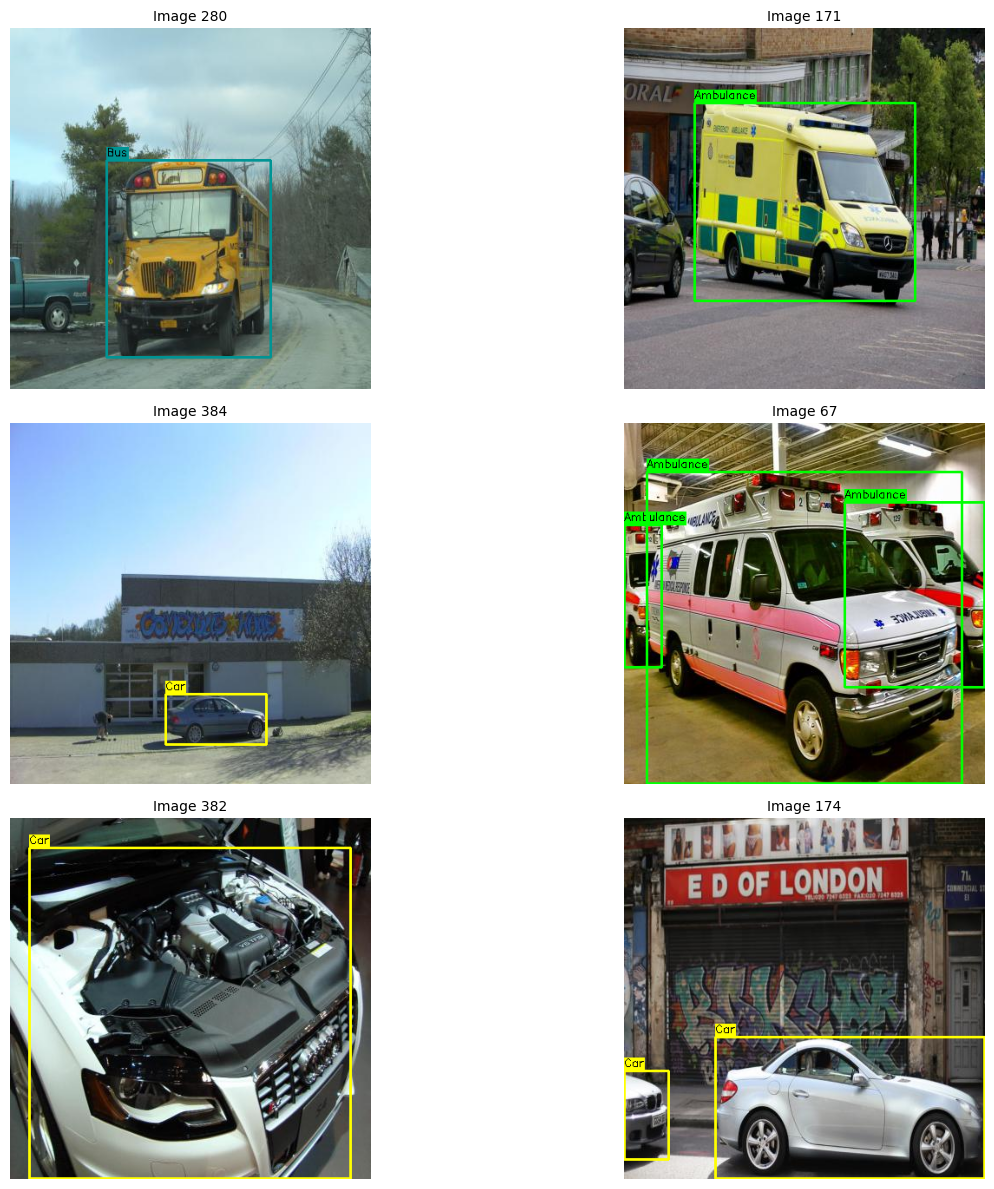

In [34]:
#run the plotting function
annot_plot(
    image_paths='/content/train/images/*',
    label_paths='/content/train/labels/*',
    class_names=class_names,
    colors=class_colors,
    num_samples=6,
    sp_rows=3,
    sp_cols=2,
    random_seed=35 #for reproduciblity

)

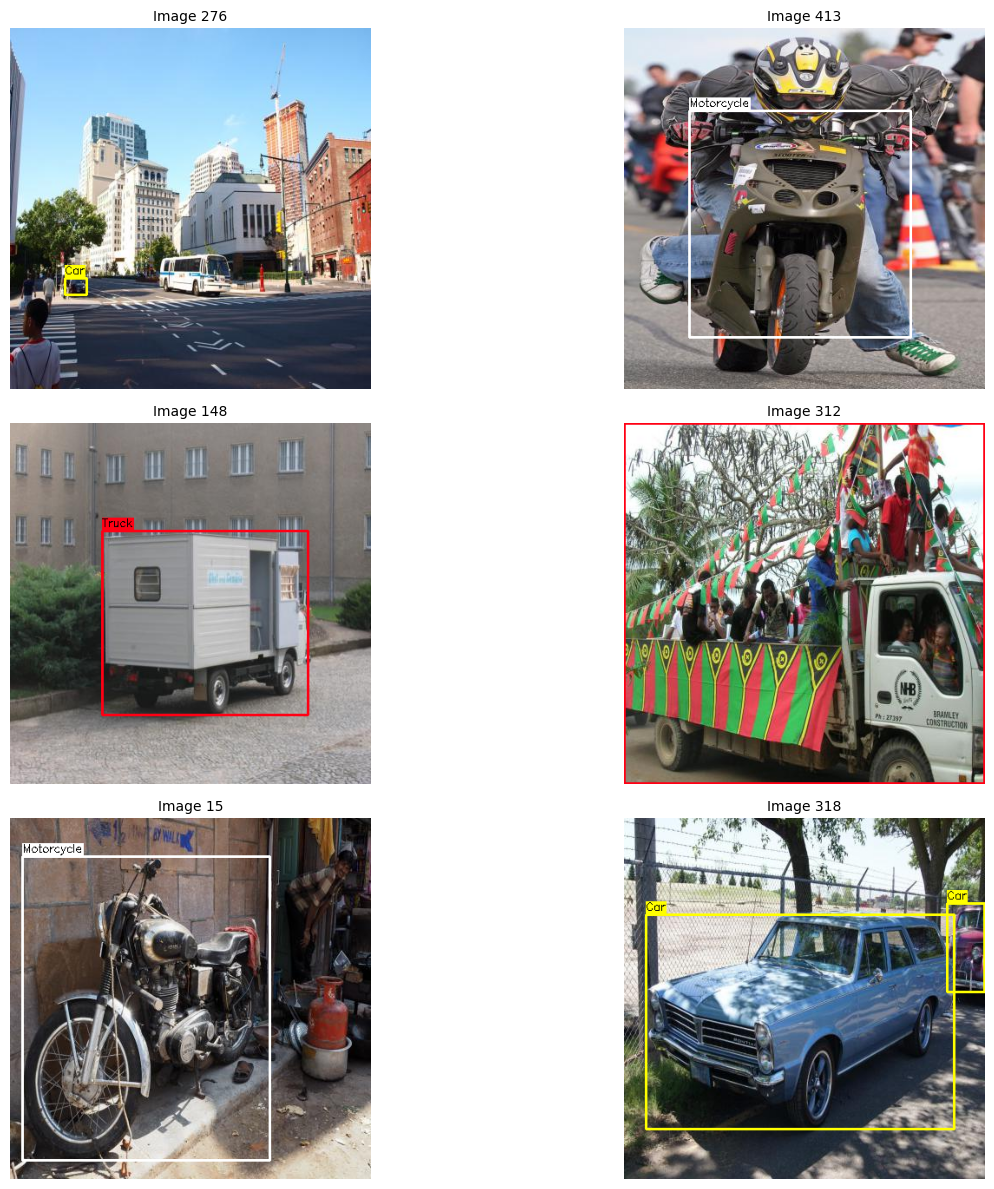

In [35]:
#run the plotting function
annot_plot(
    image_paths='/content/train/images/*',
    label_paths='/content/train/labels/*',
    class_names=class_names,
    colors=class_colors,
    num_samples=6,
    sp_rows=3,
    sp_cols=2,
    random_seed=30 #for reproduciblity

)

> It's always recommended to inspect the data to make sure the annotation is appropriate and the images have good quality.
**Attention: The bus in the top left image isn’t annotated. This will mislead the model.**

### Training YOLO

In [36]:
model = YOLO(MODEL_INIT)

In [37]:
train_results = model.train(
                            data=DATA_YAML,
                            epochs=EPOCHS,
                            imgsz=IMG,
                            batch=BATCH,
                            device=DEVICE,
                            workers=WORKERS,
                            patience=PATIENCE,
                            save_period=SAVE_PERIOD,
                            cache=True,
                            project='runs/detect',
                            name=RUN_NAME,
                            plots=True
                            )
print('-'*40)
print('Training complete. Best weights at:', f'runs/detect/{RUN_NAME}/weights/best.pt')

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_20251114_185042, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, p

Evaluate on test set

In [38]:
# Evaluate on test set
metrics = model.val(data=DATA_YAML, split='test')
print(metrics.box.map)  # mean Average Precision (mAP)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1111.4±470.2 MB/s, size: 36.4 KB)
val: Scanning /content/test/labels... 63 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 63/63 1.5Kit/s 0.0s
val: New cache created: /content/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.9it/s 1.4s
                   all         63        129      0.839      0.703      0.778      0.568
             Ambulance          9          9      0.826          1      0.995      0.945
                   Bus         11         19       0.86      0.789       0.83      0.584
                   Car         30         75      0.786       0.54      0.677      0.445
            Motorcycle          6         16      0.885      0.484      0.605      0.258
    

### Testing the Model On Unseen Data from the Web

In [69]:
# !rm -rf downloads inference_images inference_videos downloads_detect

In [66]:
import os
import requests

def download_data(url, save_name, folder="downloads"):
    """
    Download a file from a given URL and save it to a folder.
    If the folder doesn't exist, create it.
    """
    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Add file extension if missing
    if not os.path.splitext(save_name)[1]:
        save_name += os.path.splitext(url)[-1]

    save_path = os.path.join(folder, save_name)

    if not os.path.exists(save_path):
        print(f"Downloading {save_name}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(8192):
                    f.write(chunk)
            print(f"✅ Download complete: {save_path}")
        except Exception as e:
            print(f"❌ Download failed: {e}")
    else:
        print(f"⚠️ File already exists: {save_path}")


In [70]:
data_url_1 = 'https://source.roboflow.com/WpZ4esJSYmM1MiDzYEPombDsxND3/278o3ukLpk3oTRAQYjj7/original.jpg'
download_data(data_url_1, 'ambulance1')

data_url_2 = 'https://s0.geograph.org.uk/geophotos/04/44/27/4442742_4d5357d0.jpg'
download_data(data_url_2, 'ambulance2')

data_url_3 = 'https://longdistancetowing.com/wp-content/uploads/2025/01/Can-I-Park-My-Commercial-Truck-at-Home-1024x683.jpg.webp'
download_data(data_url_3, 'street3')

data_url_4 = 'https://nccaraccidentlawyers.com/wp-content/uploads/2025/04/lane-splitting.jpg'
download_data(data_url_4, 'street4')

✅ Download complete: downloads/ambulance1.jpg
✅ Download complete: downloads/ambulance2.jpg
✅ Download complete: downloads/street3.webp
✅ Download complete: downloads/street4.jpg


In [71]:
pred_results = model.predict(
    source='/content/downloads',
    # only use predictions with confidence score above 0.45
    conf=0.25,
    #overlap criteria of bounding boxes
    iou=0.45,
    imgsz=IMG,
    project='/content/downloads',
    name='results',
    save=True,
    exist_ok=True
)


image 1/4 /content/downloads/ambulance1.jpg: 480x640 1 Ambulance, 4 Cars, 11.3ms
image 2/4 /content/downloads/ambulance2.jpg: 384x640 1 Ambulance, 2 Motorcycles, 1 Truck, 9.3ms
image 3/4 /content/downloads/street3.webp: 448x640 2 Trucks, 9.6ms
image 4/4 /content/downloads/street4.jpg: 448x640 7 Cars, 1 Motorcycle, 9.0ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/downloads/results


For videos

In [72]:
def download_data(url, save_name, unzip_flag):
  #check if the file already exists
  if not os.path.exists(save_name):
    #download the file
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)
  else:
    print('File already exists, skipping download - or use a different name.')

  if unzip_flag:
    #check if the file already exists
    if not os.path.exists(save_name[:-4]): #remove the .zip extension using the string index
      !unzip -q {save_name}
    else:
      print('Image data already exists')

In [73]:
data_url = 'https://learnopencv.s3.us-west-2.amazonaws.com/yolov5_inference_data.zip'

download_data(data_url, 'testing_data.zip', unzip_flag=True)

File already exists, skipping download - or use a different name.


In [74]:
pred_results = model.predict(
    source='/content/inference_videos',
    # only use predictions with confidence score above 0.45
    conf=0.25,
    #overlap criteria of bounding boxes
    iou=0.45,
    imgsz=IMG,
    project='/content/inference_videos',
    name='results',
    save=True,
    exist_ok=True
)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/4 (frame 1/513) /content/inference_videos/video_1.mp4: 384x640 (no detections), 11.3ms
video 1/4 (frame 2/513) /content/inference_videos/video_1.mp4: 384x640 4 Cars, 9.5ms
video 1/4 (frame 3/513) /content/inference_videos/video_1.mp4: 384x640 4 Cars, 1 Truck, 9.4ms
video 1/4 (frame 4/513) /content/inference_videos/video_1.mp4: 384x640 4 Cars, 1 Truck, 10.2ms
video 1/4 (frame 5/513) /content/inference_videos/video_1.mp4: 384x640 1 Bus, 4 Cars, 9

### Model Performance Summary

- The YOLOv8-Medium model performed well on the **test set**, achieving an overall **mAP50 of 0.78**.  
- It showed strong accuracy for **Ambulance** (mAP50 = 0.995) and **Bus**, while **Motorcycle** had lower scores due to limited samples.  
- The model also performed well when tested on **random online images and videos**, showing good generalization.  
- Some training images were **missing or incomplete annotations**, which could mislead the model.  
- With **more diverse data** and **cleaner labels**, the detection accuracy is expected to improve further.  
